<a href="https://colab.research.google.com/github/Soubhagya0037/Pairs-Trading-Algorithm/blob/main/Pairs_Trading_Algorithm2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collect Historical Price Data

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of stock tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NFLX", "NVDA", "BABA", "INTC", "CSCO", "ORCL", "IBM", "ADBE"]

# Download historical price data
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']

# Check for missing values
print(data.isnull().sum())

# Fill missing values by forward filling
data.fillna(method='ffill', inplace=True)

# Check again for missing values
print(data.isnull().sum())

[*********************100%%**********************]  13 of 13 completed

Ticker
AAPL     0
ADBE     0
AMZN     0
BABA     0
CSCO     0
GOOGL    0
IBM      0
INTC     0
MSFT     0
NFLX     0
NVDA     0
ORCL     0
TSLA     0
dtype: int64
Ticker
AAPL     0
ADBE     0
AMZN     0
BABA     0
CSCO     0
GOOGL    0
IBM      0
INTC     0
MSFT     0
NFLX     0
NVDA     0
ORCL     0
TSLA     0
dtype: int64


# Identify Pairs with High Degree of Cointegration

Choosing the Significance Level
1) Conservative Approach (α = 0.05): Using a 5% significance level reduces the risk of false positives (incorrectly identifying a pair as cointegrated). This is a stricter criterion and may result in fewer identified pairs.

2) Liberal Approach (α = 0.10): Using a 10% significance level increases the likelihood of identifying more pairs as cointegrated, but also increases the risk of false positives.

We will take the second for better result

In [6]:
# Function to find cointegrated pairs
def find_cointegrated_pairs(data, significance_level=0.10):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data.iloc[:, i]
            S2 = data.iloc[:, j]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance_level:  # Adjusted significance level
                pairs.append((data.columns[i], data.columns[j]))
    return score_matrix, pvalue_matrix, pairs

# Find cointegrated pairs with a 10% significance level
scores, pvalues, pairs = find_cointegrated_pairs(data, significance_level=0.10)
if not pairs:
    raise ValueError("No cointegrated pairs found")
print("Cointegrated pairs:", pairs)

Cointegrated pairs: [('CSCO', 'GOOGL'), ('MSFT', 'ORCL')]


# Visualisation

Daily Returns of Selected Assets:

This plot shows the daily returns of each asset in the selected universe. It helps to understand the individual performance and volatility of each asset.

Returns head:
Ticker          AAPL      ADBE      AMZN      BABA      CSCO     GOOGL  \
Date                                                                     
2020-01-03 -0.009722 -0.007834 -0.012139 -0.012604 -0.016315 -0.005231   
2020-01-06  0.007968  0.005726  0.014886 -0.001659  0.003569  0.026654   
2020-01-07 -0.004703 -0.000959  0.002092  0.004570 -0.006485 -0.001932   
2020-01-08  0.016086  0.013438 -0.007809  0.001700  0.000632  0.007118   
2020-01-09  0.021241  0.007636  0.004799  0.017339 -0.004209  0.010498   

Ticker           IBM      INTC      MSFT      NFLX      NVDA      ORCL  \
Date                                                                     
2020-01-03 -0.007975 -0.012163 -0.012452 -0.011855 -0.016006 -0.003522   
2020-01-06 -0.001787 -0.002829  0.002584  0.030469  0.004194  0.005208   
2020-01-07  0.000671 -0.016686 -0.009118 -0.015127  0.012107  0.002220   
2020-01-08  0.008346  0.000679  0.015929  0.025729  0.001876  0.003895   
2020-01-09  0.010569  0

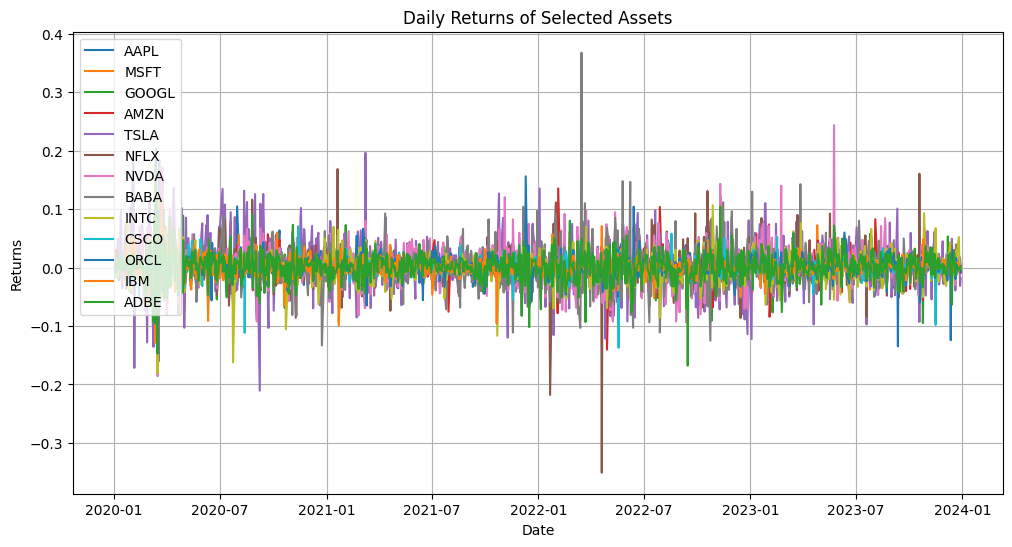

In [7]:
# Calculate returns
returns = data.pct_change().dropna()
print("Returns head:")
print(returns.head())

# Plot the daily returns
plt.figure(figsize=(12, 6))
for asset in tickers:
    plt.plot(returns.index, returns[asset], label=asset)
plt.title('Daily Returns of Selected Assets')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

This heatmap displays the correlation coefficients between the returns of the selected assets. Higher correlation coefficients indicate stronger linear relationships between asset pairs.

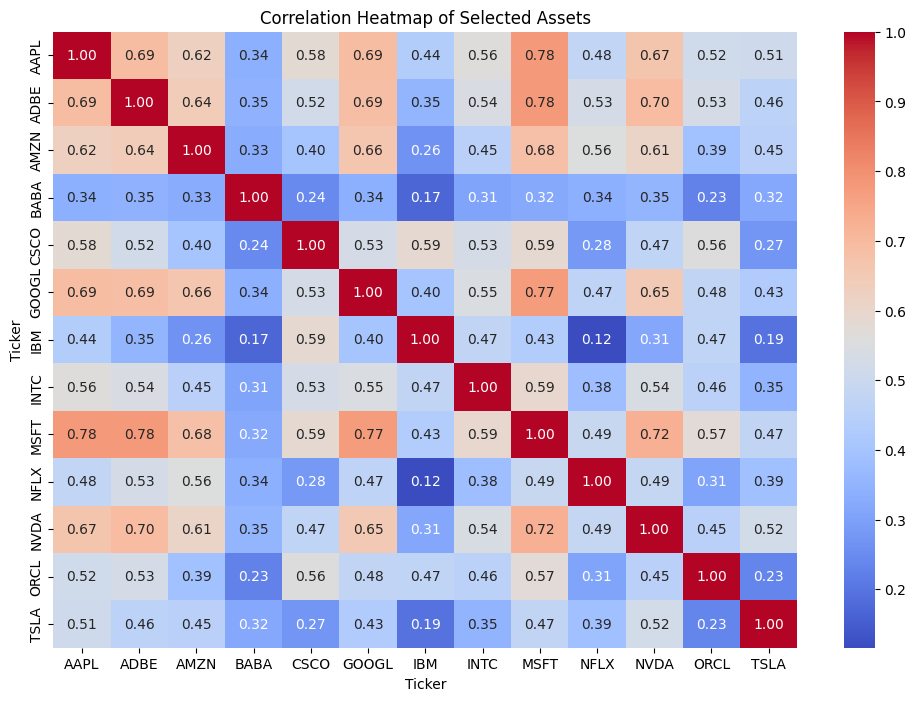

In [8]:
# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Selected Assets')
plt.show()

Spread between Cointegrated Pairs:

This plot shows the spread (difference in returns) between each cointegrated pair over time. Cointegrated pairs should exhibit mean-reverting behavior in their spread.

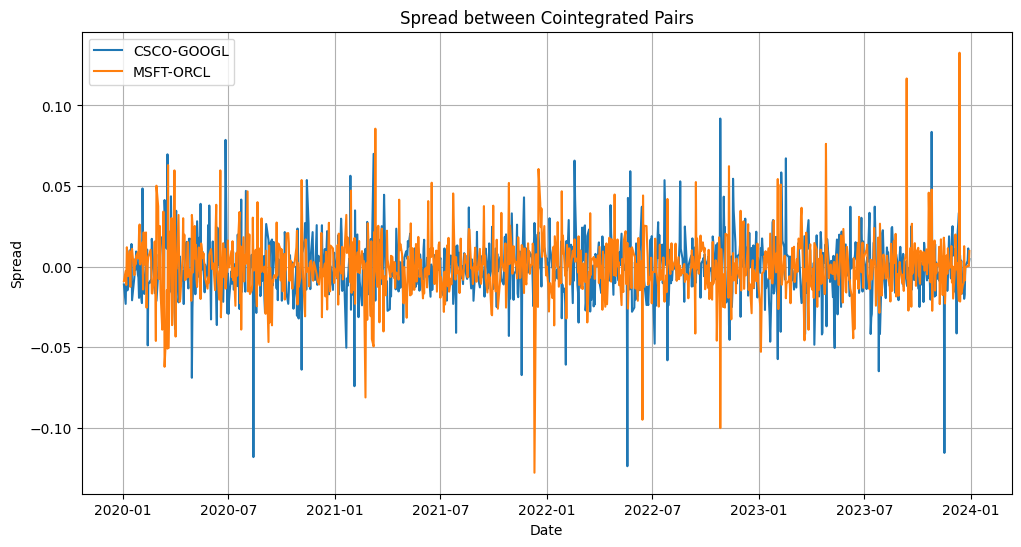

In [9]:
# Plot the cointegrated pairs
plt.figure(figsize=(12, 6))
for pair in pairs:
    asset1, asset2 = pair
    spread = returns[asset1] - returns[asset2]
    plt.plot(returns.index, spread, label=f"{asset1}-{asset2}")
plt.title('Spread between Cointegrated Pairs')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

30-Day Rolling Correlation of Cointegrated Pairs:

This additional plot shows the 30-day rolling correlation between each cointegrated pair. It helps to visualize how the correlation between pairs changes over time.

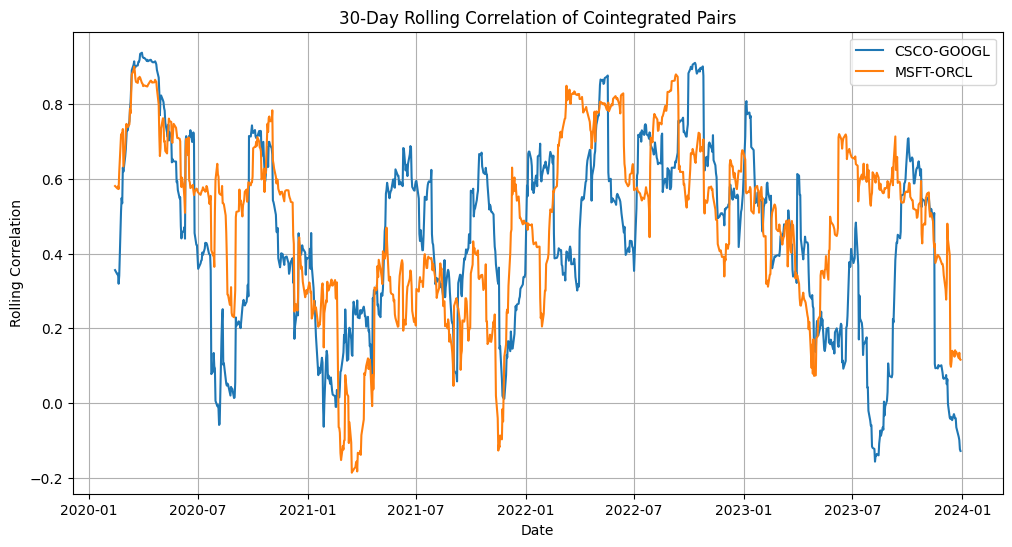

In [16]:
# Rolling Correlation of Cointegrated Pairs
plt.figure(figsize=(12, 6))
for pair in pairs:
    asset1, asset2 = pair
    rolling_corr = returns[asset1].rolling(window=30).corr(returns[asset2])
    plt.plot(returns.index, rolling_corr, label=f"{asset1}-{asset2}")
plt.title('30-Day Rolling Correlation of Cointegrated Pairs')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.legend()
plt.grid(True)
plt.show()

Rolling Mean and Standard Deviation of Spread for Cointegrated Pairs:

This plot shows the rolling mean and standard deviation of the spread for each cointegrated pair. The shaded area represents ±1 standard deviation around the rolling mean, providing insights into the volatility of the spread.

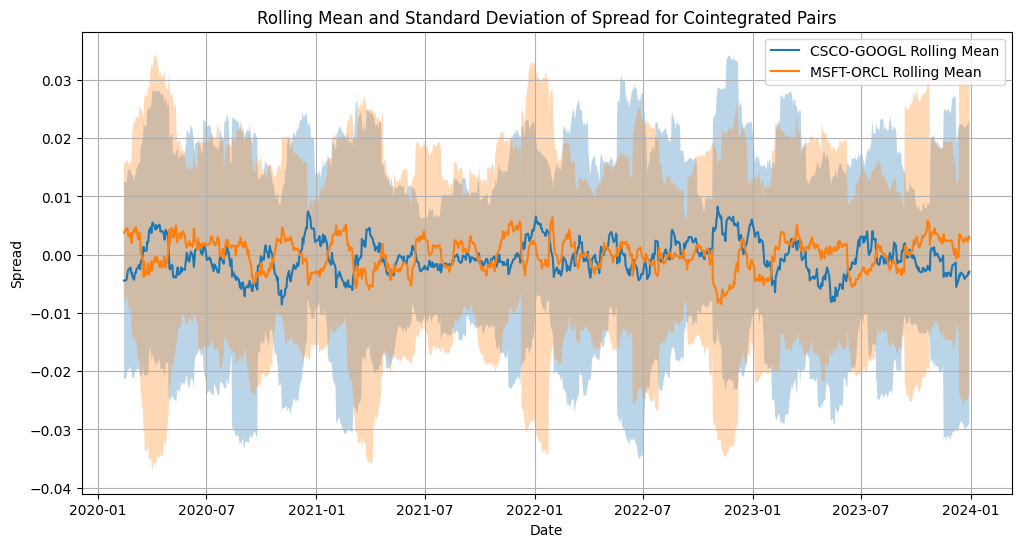

In [17]:
#Rolling Mean and Std of Spread for Cointegrated Pairs
plt.figure(figsize=(12, 6))
for pair in pairs:
    asset1, asset2 = pair
    spread = returns[asset1] - returns[asset2]
    rolling_mean = spread.rolling(window=30).mean()
    rolling_std = spread.rolling(window=30).std()
    plt.plot(returns.index, rolling_mean, label=f"{asset1}-{asset2} Rolling Mean")
    plt.fill_between(returns.index, rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.3)
plt.title('Rolling Mean and Standard Deviation of Spread for Cointegrated Pairs')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

# Develop a Trading Algorithm

In [10]:
# Function to calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Example pair
pair = pairs[0]
S1 = data[pair[0]]
S2 = data[pair[1]]

# Calculate the spread
spread = S1 - S2

# Calculate the z-score of the spread
zscore_spread = zscore(spread)

# Define thresholds for trading signals
entry_threshold = 2.0
exit_threshold = 0.5

# Generate signals
data['position'] = np.where(zscore_spread > entry_threshold, -1, 0)  # Short the spread
data['position'] = np.where(zscore_spread < -entry_threshold, 1, data['position'])  # Long the spread
data['position'] = np.where(np.abs(zscore_spread) < exit_threshold, 0, data['position'])  # Exit position

# Shift the position by 1 day to align with next day's returns
data['position'] = data['position'].shift(1)


# Backtest the Algorithm

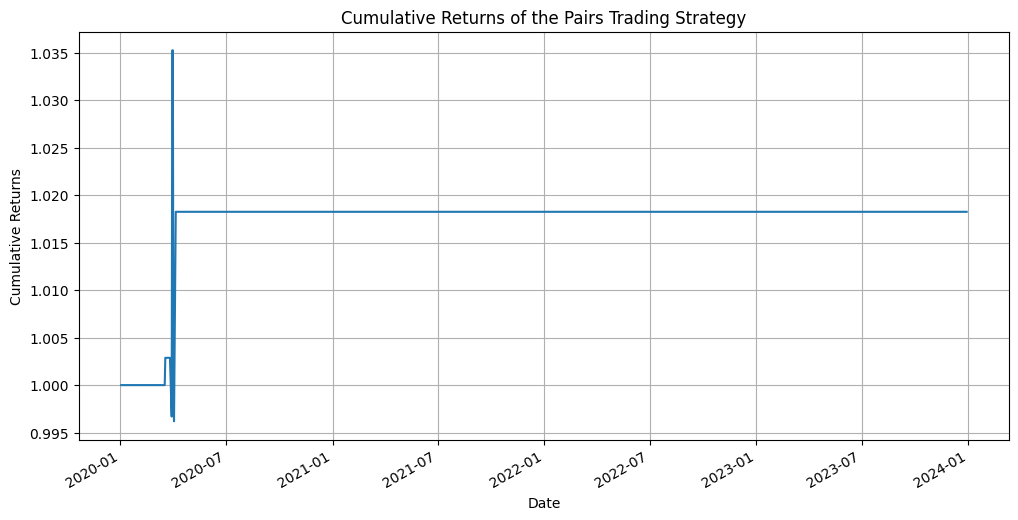

In [11]:
# Calculate daily returns
data['returns'] = data[pair[0]].pct_change() - data[pair[1]].pct_change()

# Calculate strategy returns
data['strategy_returns'] = data['position'] * data['returns']

# Calculate cumulative returns
data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
data['cumulative_returns'].plot()
plt.title('Cumulative Returns of the Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Optimize the Algorithm

In [15]:
from itertools import product

def optimize_strategy(data, pair):
    best_sharpe = -np.inf
    best_params = None
    thresholds = np.arange(0.5, 3.5, 0.5)
    for entry_threshold, exit_threshold in product(thresholds, repeat=2):
        # Calculate z-score of the spread
        spread = data[pair[0]] - data[pair[1]]
        zscore_spread = zscore(spread)

        # Generate signals
        data['position'] = np.where(zscore_spread > entry_threshold, -1, 0)
        data['position'] = np.where(zscore_spread < -entry_threshold, 1, data['position'])
        data['position'] = np.where(np.abs(zscore_spread) < exit_threshold, 0, data['position'])
        data['position'] = data['position'].shift(1)

        # Calculate strategy returns
        data['strategy_returns'] = data['position'] * (data[pair[0]].pct_change() - data[pair[1]].pct_change())

        # Calculate Sharpe ratio
        sharpe_ratio = data['strategy_returns'].mean() / data['strategy_returns'].std() * np.sqrt(252)

        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_params = (entry_threshold, exit_threshold)

    return best_params, best_sharpe

best_params, best_sharpe = optimize_strategy(data, pair)
print("Best parameters:", best_params)
print("Best Sharpe ratio:", best_sharpe)

<ipython-input-15-8102b7531146>:22: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = data['strategy_returns'].mean() / data['strategy_returns'].std() * np.sqrt(252)


Best parameters: (0.5, 0.5)
Best Sharpe ratio: 0.8911003312404294
